In [33]:
import zipfile
import os

zip_file_name = "/Bean_Dataset.zip"
extraction_directory = "extracted_dataset"

if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

In [37]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Update data_dir to point to the directory containing the class subfolders
data_dir = "extracted_dataset/Bean_Dataset"

image_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=data_transforms
)

#Splitting into trainng and testing data
train_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_size
train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])

batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

print(f"Dataset split into {len(train_dataset)} training images and {len(test_dataset)} testing images.")

Dataset split into 792 training images and 198 testing images.


In [38]:
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FeedforwardNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

input_size = 224 * 224 * 3
# Correctly setting num_classes based on the dataset
num_classes = len(image_dataset.classes)
model = FeedforwardNet(input_size, num_classes)
print(f"Feedforward model created with {num_classes} classes.")

Feedforward model created with 3 classes.


In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Loss function (Cross-Entropy) and Optimizer (Adam) defined.")

Loss function (Cross-Entropy) and Optimizer (Adam) defined.


In [40]:
num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

#Calculating loss over training data
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished.")

Epoch [1/10], Loss: 6.7721
Epoch [2/10], Loss: 1.5177
Epoch [3/10], Loss: 0.7327
Epoch [4/10], Loss: 0.4892
Epoch [5/10], Loss: 0.3269
Epoch [6/10], Loss: 0.2248
Epoch [7/10], Loss: 0.2004
Epoch [8/10], Loss: 0.0993
Epoch [9/10], Loss: 0.0720
Epoch [10/10], Loss: 0.0536
Training finished.


In [42]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

print(f"Accuracy of the model on the {total} images: {accuracy:.2f}%")

Accuracy of the model on the 198 images: 63.13%


In [43]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculating precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.6757
Recall: 0.6313
F1-score: 0.6256


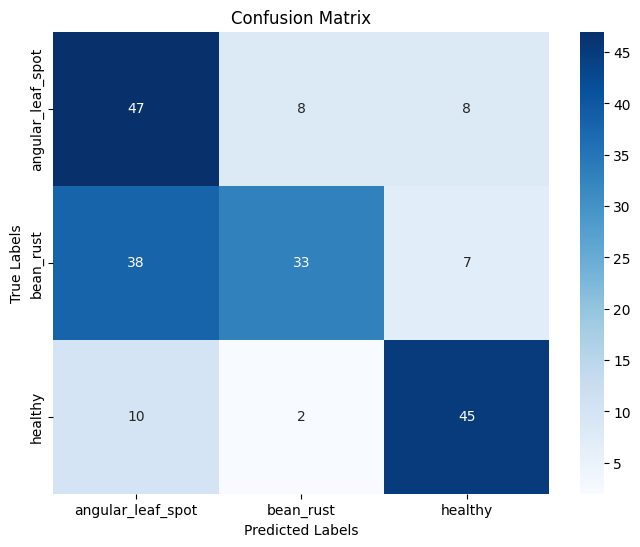

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_dataset.classes, yticklabels=image_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()